# Certainty Assessment for ANN-Based QRS Detectors

## Preparation

Before you can use this notebook, you have to download the following databases:
 * MIT-BIH Arrhythmia Database (`mitdb`, for training)  
 Moody GB, Mark RG. The impact of the MIT-BIH Arrhythmia Database. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)
 [https://physionet.org/physiobank/database/mitdb/](https://physionet.org/physiobank/database/mitdb/)
 * MIT-BIH Noise Stress Test Database (`nstdb`, for testing)  
 Moody GB, Muldrow WE, Mark RG. A noise stress test for arrhythmia detectors. Computers in Cardiology 1984; 11:381-384.
 [https://physionet.org/physiobank/database/nstdb/](https://physionet.org/physiobank/database/nstdb/)

You can do this with the script provided in the repository:
```shell
./download_databases.py -d data -k mitdb nstdb
```

In [1]:
import matplotlib.pyplot as plt
import sys
import wfdb

sys.path.append("..")

from raccoon.detectors import XiangDetector
from raccoon.utils.annotationutils import trigger_points
from raccoon.utils.triggerutils import signal_to_points

Using TensorFlow backend.


## Read Records

In [2]:
def read_record(path, sampfrom, sampto):
    record = wfdb.rdrecord(path, sampfrom=sampfrom, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampfrom=sampfrom, sampto=sampto)
    trigger = [tp-sampfrom for tp in trigger_points(annotation)]
    return record, trigger

def read_records(directory, names, sampfrom, sampto):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampfrom, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
# Training data without added noise:
train_dir = "../physionet.org/files/mitdb/1.0.0"
train_names = ["100", "101", "102", "103", "104"]

# Test data with added noise and known SNR.
test_dir = "../physionet.org/files/nstdb/1.0.0"
test_names = ["118e12", "118e18", "118e24"]
plot_titles = [
    "Record 118 (SNR = 12dB)",
    "Record 118 (SNR = 18dB)",
    "Record 118 (SNR = 24dB)"]

# Not the whole signal is noisy, so we have to select a noisy part:
sampfrom = 140000
sampto = 150000

train_records, train_triggers = read_records(
    train_dir, train_names, sampfrom, sampto)
test_records, test_triggers = read_records(
    test_dir, test_names, sampfrom, sampto)

## Train

In [4]:
# XiangDetector is one of three neural network based detectors.
# You can try others if you like:
# 
# detector = GarciaBerdonesDetector(
#     name = "GarciaBerdones01",
#     batch_size = 32,
#     window_size = 20,
#     epochs = 3)

# detector = SarlijaDetector(
#     name = "Sarlija01",
#     batch_size = 32,
#     window_size = 50,
#     detection_size = 10,
#     epochs=3)

detector = XiangDetector(
    name = "Xiang01",
    batch_size = 32,
    window_size = 60,
    detection_size = 10,
    aux_ratio = 5,
    epochs = 3)

detector.train(train_records, train_triggers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
1553/1553 [==============================] - 8s 5ms/step - loss: 0.0493
Epoch 2/3

1553/1553 [==============================] - 7s 5ms/step - loss: 0.0230
Epoch 3/3
1553/1553 [==============================] - 7s 5ms/step - loss: 0.0211


## Test

In [5]:
trigger_signals = detector.trigger_signals(test_records)

detected_triggers, certainties = tuple(zip(*[
    signal_to_points(
        trigger_signal,
        threshold=.01, # Higher values mean fewer trigger points, try changing!
        with_certainty=True)
    for trigger_signal in trigger_signals]))

detected_triggers, certainties = list(detected_triggers), list(certainties)

## Plot

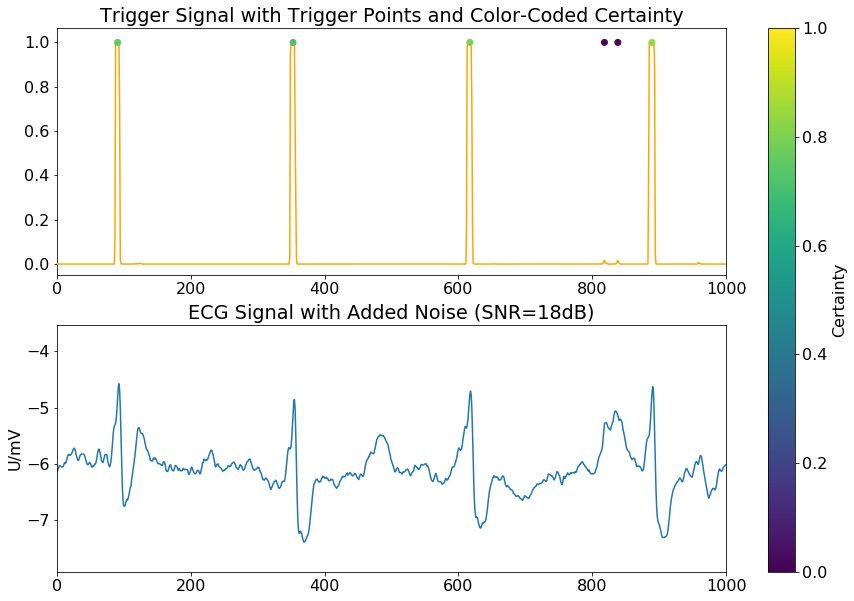

In [6]:
idx=1

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(ncols=1, nrows=2)
ax_ts, ax_ecg = axes
fig.set_size_inches(15,10)

ax_ts.plot(trigger_signals[idx], color='orange', zorder=5)
tp = ax_ts.scatter(
    detected_triggers[idx], [1]*len(detected_triggers[idx]),
    c=certainties[idx], cmap='viridis', vmin=0, vmax=1, zorder=10)
ax_ts.set_xlim(0,1000)
ax_ts.set_title("Trigger Signal with Trigger Points and Color-Coded Certainty")

ax_ecg.plot(test_records[idx].p_signal.T[0])
ax_ecg.set_xlim(0,1000)
ax_ecg.set_ylabel("U/mV")
ax_ecg.set_title("ECG Signal with Added Noise (SNR=18dB)")

fig.colorbar(tp, ax=axes.ravel().tolist(), label="Certainty")

plt.show()

In [7]:
save = True

if save:
    fig.savefig(
        '../generated/figures/certainty.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)